In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import gc
import pickle
import numpy as np
from tqdm import tqdm
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csc_matrix
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

In [2]:
df = pd.read_pickle('./train_set.pkl')
df.drop(['id'], axis=1, inplace=True)
df.drop_duplicates(inplace=True)
df.shape

(149690, 3)

In [3]:
tid_label_encoder = LabelEncoder()
tid_label_encoder.fit(df['tid'])

user_label_encoder = LabelEncoder()
user_label_encoder.fit(df['userName'])

df['tid_enc'] = tid_label_encoder.transform(df['tid'])
df['user_enc'] = user_label_encoder.transform(df['userName'])

In [4]:
h = df.nunique()
h

tid         3676
userName     647
rating        10
tid_enc     3676
user_enc     647
dtype: int64

In [5]:
frequent_set = {}
for row in tqdm(df.itertuples()):
    if row.rating>=8:
        if row.user_enc not in frequent_set:
            frequent_set[row.user_enc] = []
        
        frequent_set[row.user_enc].append(row.tid_enc)

149690it [00:00, 547773.00it/s]


In [6]:
frequent_data = list(frequent_set.values())

In [7]:
te = TransactionEncoder()
te_ary = te.fit(frequent_data).transform(frequent_data)
te_df = pd.DataFrame(te_ary, columns=te.columns_)

In [26]:
fp_model = fpgrowth(te_df, min_support=0.015, max_len=2)

In [27]:
colum_index = te_df.columns
CF_subset = {}
for index, row in tqdm(fp_model.iterrows()):
    if len(row.itemsets)==2:
        id_set =  list(row.itemsets)
        from_id = id_set[0]
        to_id = id_set[1]
        
        if colum_index[from_id] not in CF_subset:
            CF_subset[colum_index[from_id]] = []
        if colum_index[to_id] not in CF_subset:
            CF_subset[colum_index[to_id]] = []
        
        CF_subset[colum_index[from_id]].append(colum_index[to_id])
        CF_subset[colum_index[to_id]].append(colum_index[from_id])

17678it [00:02, 6799.10it/s]


In [28]:
for key in list(CF_subset.keys()):
    if len(CF_subset[key])<5:
        del CF_subset[key]

In [29]:
size_list = []
for key in CF_subset:
    size_list.append(len(CF_subset[key]))

In [30]:
len(CF_subset)

709

In [31]:
rows = df['user_enc'].values
columns = df['tid_enc'].values
data = df['rating'].values

user_item_matrix = csc_matrix((data, (rows, columns)), shape=(h.user_enc, h.tid_enc))

In [32]:
def UCF_ICF_NoPrior(row_enc, col_enc, user_item_matrix, k, cross_method, distance_method, CF_subset, herachine):  
    union_user_list = np.where(user_item_matrix[:, col_enc].toarray()>0)[0]

    if len(union_user_list)>0:
        est_user = user_item_matrix[row_enc].toarray().reshape([-1])
        est_user[col_enc] = 0.0
        if cross_method:
            est_user_index = (est_user>0).astype(np.int)
            
        simliary_list = []
        union_user = []
        for user in union_user_list:
            com_user = user_item_matrix[user].toarray().reshape([-1])
            com_user[col_enc] = 0.0

            if herachine:
                est_user_v = est_user[CF_subset[col_enc]]
                com_user_v = com_user[CF_subset[col_enc]]
            else:
                est_user_v = est_user
                com_user_v = com_user
            
            if cross_method:
                com_user_index = (com_user>0).astype(np.int)
                cross_index = est_user_index*com_user_index
                
                if np.sum(cross_index)==0:
                    continue
                
                est_user_v = est_user[cross_index==1]
                com_user_v = com_user[cross_index==1]
            
            if distance_method=='Cosin':
                num = np.sum(est_user_v * com_user_v)
                denom = np.linalg.norm(est_user_v) * np.linalg.norm(com_user_v)
                sim = num / (denom+1e-8) #余弦值 
            elif distance_method=='Person':
                sim = np.corrcoef(est_user_v, com_user_v)[0, 1]
            else:
                return None, None
            
            simliary_list.append(sim)
            union_user.append(user)

        simliary_list = np.array(simliary_list)
        simliary_list = simliary_list[simliary_list>0.0]
        argindex = np.argsort(simliary_list)[-k:]
        
        sum_of_score = 0
        sum_of_similary = 0
        for index in argindex:
            sum_of_similary += simliary_list[index]
            sum_of_score += user_item_matrix[union_user[index], col_enc]*simliary_list[index]
        
        return sum_of_score/(sum_of_similary+1e-8), simliary_list[argindex].mean()
        
    return None, None

In [33]:
test_col_index = np.array(list(CF_subset.keys()))
test_col_index[0]

3428

In [34]:
UCF_ICF_NoPrior(0, 3428, user_item_matrix, k=5, cross_method=False, distance_method='Cosin', CF_subset=CF_subset, herachine=True)

(8.414973528751736, 0.44997352302618926)

In [35]:
test_set = df[df['tid_enc'].isin(test_col_index)][['tid_enc', 'user_enc', 'rating']]

In [36]:
user_rating_list = []
user_rating_c_list = []
user_rating_sub_list = []
user_rating_c_sub_list = []
real_rating = []

sample_num = 0
while sample_num<=1000:
    sample = test_set.sample(1)
    row_id = sample.user_enc.values[0]
    col_id = sample.tid_enc.values[0]
    rating = sample.rating.values[0]
    
    user_rating_c_sub = UCF_ICF_NoPrior(row_id, col_id, user_item_matrix, k=5, cross_method=True, distance_method='Cosin', CF_subset=CF_subset, herachine=True)[0]
    if user_rating_c_sub==0:
        continue
    
    user_rating_sub = UCF_ICF_NoPrior(row_id, col_id, user_item_matrix, k=5, cross_method=False, distance_method='Cosin', CF_subset=CF_subset, herachine=True)[0]
    if user_rating_sub==0:
        continue
        
    user_rating = UCF_ICF_NoPrior(row_id, col_id, user_item_matrix, k=5, cross_method=False, distance_method='Cosin', CF_subset=CF_subset, herachine=False)[0]
    user_rating_c = UCF_ICF_NoPrior(row_id, col_id, user_item_matrix, k=5, cross_method=True, distance_method='Cosin', CF_subset=CF_subset, herachine=False)[0]
    
    user_rating_list.append(user_rating)
    user_rating_c_list.append(user_rating_c)
    user_rating_sub_list.append(user_rating_sub)
    user_rating_c_sub_list.append(user_rating_c_sub)
    real_rating.append(rating)
    
    sample_num += 1
    print('iteration:%d'%sample_num, '%f %f, %f, %f, %f'%(rating, user_rating_c_sub, user_rating_sub, user_rating_c, user_rating))

iteration:1 7.000000 7.398728, 7.919203, 7.398728, 8.259656
iteration:2 4.000000 6.587167, 7.034713, 6.587167, 6.733444
iteration:3 9.000000 8.401634, 8.361321, 8.401634, 8.487522
iteration:4 10.000000 8.001397, 7.429685, 8.001397, 9.085386
iteration:5 2.000000 6.980036, 5.936982, 6.980036, 5.800398
iteration:6 7.000000 7.798901, 8.531990, 7.798901, 7.337136
iteration:7 8.000000 7.400244, 8.469925, 7.400244, 7.524248
iteration:8 8.000000 7.802153, 8.340239, 7.802153, 8.658664
iteration:9 9.000000 8.601771, 9.354599, 8.601771, 8.034107
iteration:10 5.000000 6.592165, 7.396638, 6.592165, 6.126342
iteration:11 10.000000 8.603705, 9.261573, 8.603705, 8.759360
iteration:12 9.000000 7.006149, 8.211826, 7.006149, 8.384994
iteration:13 8.000000 8.796727, 8.007157, 8.796727, 7.846323
iteration:14 7.000000 7.797168, 8.518206, 7.797168, 8.126978
iteration:15 5.000000 6.203010, 8.001001, 6.203010, 6.202637
iteration:16 10.000000 7.802499, 6.878049, 7.802499, 9.230090
iteration:17 6.000000 7.394268

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice.
D:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


iteration:18 10.000000 9.201152, 9.269442, 9.201152, 8.954210
iteration:19 7.000000 7.992200, 8.819978, 7.992200, 7.962882
iteration:20 10.000000 8.008686, 8.604634, 8.008686, 9.474196
iteration:21 6.000000 7.394042, 6.834632, 7.394042, 7.907443
iteration:22 9.000000 7.802846, 6.954598, 7.802846, 8.789717
iteration:23 8.000000 7.401819, 8.458802, 7.401819, 8.356063
iteration:24 7.000000 8.596768, 8.544613, 8.596768, 8.601825
iteration:25 10.000000 8.407746, 9.160889, 8.407746, 8.531288
iteration:26 5.000000 6.996709, 8.205930, 6.996709, 5.966913
iteration:27 10.000000 7.399992, 7.704605, 7.399992, 9.589363
iteration:28 6.000000 7.998530, 7.963162, 7.998530, 6.792673
iteration:29 9.000000 7.200000, 8.106350, 7.200000, 8.391093
iteration:30 8.000000 8.397502, 6.940803, 8.397502, 7.451894
iteration:31 7.000000 7.787601, 7.450824, 7.787601, 7.549515
iteration:32 5.000000 7.788263, 6.613150, 7.788263, 6.297289
iteration:33 9.000000 8.401702, 8.803889, 8.401702, 8.961664
iteration:34 10.0000

iteration:151 7.000000 7.398463, 8.190350, 7.398463, 8.083703
iteration:152 8.000000 8.400314, 6.932675, 8.400314, 7.234529
iteration:153 10.000000 6.805192, 6.760380, 6.805192, 8.629515
iteration:154 10.000000 9.600291, 6.107932, 9.600291, 9.049757
iteration:155 3.000000 7.171724, 6.616169, 7.171724, 5.989423
iteration:156 10.000000 9.201061, 10.000000, 9.201061, 9.629038
iteration:157 8.000000 7.401888, 7.551549, 7.401888, 8.010750
iteration:158 8.000000 8.196367, 5.712073, 8.196367, 7.671462
iteration:159 7.000000 8.395651, 6.995876, 8.395651, 6.996585
iteration:160 8.000000 7.801947, 8.048843, 7.801947, 8.055434
iteration:161 6.000000 8.793224, 7.634282, 8.793224, 7.696825
iteration:162 10.000000 8.003186, 7.843403, 8.003186, 8.534731
iteration:163 10.000000 9.602173, 7.471165, 9.602173, 9.111411
iteration:164 6.000000 6.401858, 5.805967, 6.401858, 5.690550
iteration:165 9.000000 9.399071, 8.083335, 9.399071, 8.545161
iteration:166 6.000000 6.805873, 7.994921, 6.805873, 7.382455
it

iteration:282 8.000000 8.000283, 8.283445, 8.000283, 8.189837
iteration:283 5.000000 7.599876, 7.059281, 7.599876, 6.256513
iteration:284 6.000000 8.590871, 8.121945, 8.590871, 6.868498
iteration:285 8.000000 7.799686, 8.141867, 7.799686, 7.991122
iteration:286 8.000000 8.001878, 8.303117, 8.001878, 8.797538
iteration:287 7.000000 8.593621, 8.611432, 8.593621, 7.789065
iteration:288 9.000000 7.603724, 7.863215, 7.603724, 7.754863
iteration:289 8.000000 6.803855, 7.423594, 6.803855, 7.403732
iteration:290 10.000000 8.203505, 8.058588, 8.203505, 8.874587
iteration:291 6.000000 7.994488, 6.600000, 7.994488, 7.241407
iteration:292 8.000000 7.599406, 7.844243, 7.599406, 8.208267
iteration:293 7.000000 7.601507, 7.839378, 7.601507, 7.416243
iteration:294 8.000000 7.801802, 8.565163, 7.801802, 8.167202
iteration:295 6.000000 7.598930, 7.689632, 7.598930, 6.963174
iteration:296 10.000000 8.399983, 8.870447, 8.399983, 9.477187
iteration:297 4.000000 8.192305, 8.000000, 8.192305, 5.327432
iterat

iteration:413 9.000000 8.205671, 8.033726, 8.205671, 8.588009
iteration:414 9.000000 9.194872, 7.319377, 9.194872, 8.516567
iteration:415 8.000000 8.398784, 7.456367, 8.398784, 7.743641
iteration:416 8.000000 9.197935, 6.313088, 9.197935, 8.126755
iteration:417 9.000000 8.999285, 6.262753, 8.999285, 8.829754
iteration:418 10.000000 9.400960, 9.253014, 9.400960, 8.893535
iteration:419 8.000000 7.800669, 5.616078, 7.800669, 7.815158
iteration:420 9.000000 8.002863, 8.457164, 8.002863, 7.910496
iteration:421 10.000000 9.000009, 9.097672, 9.000009, 9.649729
iteration:422 8.000000 8.596272, 8.393755, 8.596272, 8.586596
iteration:423 4.000000 7.204621, 9.320491, 7.204621, 8.826602
iteration:424 7.000000 6.998607, 7.818707, 6.998607, 6.845575
iteration:425 8.000000 8.199368, 7.991639, 8.199368, 8.846856
iteration:426 9.000000 9.399153, 9.736811, 9.399153, 9.094167
iteration:427 6.000000 7.389666, 8.173385, 7.389666, 6.825580
iteration:428 9.000000 9.794296, 9.742122, 9.794296, 9.636518
iterat

iteration:544 6.000000 7.596106, 8.221549, 7.596106, 7.640194
iteration:545 6.000000 6.399455, 6.175293, 6.399455, 6.270504
iteration:546 8.000000 8.798396, 7.842338, 8.798396, 8.124781
iteration:547 8.000000 7.202686, 7.053510, 7.202686, 7.438449
iteration:548 9.000000 7.600122, 6.205585, 7.600122, 8.324616
iteration:549 4.000000 7.377127, 8.511745, 7.377127, 5.716493
iteration:550 8.000000 7.602304, 8.700521, 7.602304, 8.089884
iteration:551 4.000000 8.375481, 6.754966, 8.375481, 6.629887
iteration:552 8.000000 7.400162, 8.382980, 7.400162, 8.007869
iteration:553 6.000000 7.778684, 7.652511, 7.778684, 7.701277
iteration:554 9.000000 7.800150, 7.649537, 7.800150, 7.684162
iteration:555 8.000000 8.598503, 8.604013, 8.598503, 7.788375
iteration:556 9.000000 8.202316, 6.781022, 8.202316, 8.604848
iteration:557 8.000000 7.598703, 5.942052, 7.598703, 7.480571
iteration:558 9.000000 8.601771, 6.939855, 8.601771, 8.272246
iteration:559 8.000000 8.000474, 8.211429, 8.000474, 8.552424
iteratio

iteration:675 10.000000 9.201115, 7.656940, 9.201115, 9.255563
iteration:676 10.000000 9.002969, 9.138061, 9.002969, 9.154639
iteration:677 7.000000 8.197681, 7.800360, 8.197681, 7.304015
iteration:678 9.000000 7.604464, 8.057642, 7.604464, 8.000493
iteration:679 8.000000 6.202775, 8.577523, 6.202775, 6.982888
iteration:680 10.000000 8.800760, 8.234523, 8.800760, 9.057076
iteration:681 7.000000 7.799396, 7.384859, 7.799396, 5.436094
iteration:682 8.000000 7.800741, 8.084568, 7.800741, 7.505065
iteration:683 7.000000 7.398459, 7.888610, 7.398459, 7.898871
iteration:684 7.000000 7.797884, 7.003425, 7.797884, 7.113963
iteration:685 6.000000 8.195912, 7.639927, 8.195912, 7.394109
iteration:686 7.000000 7.598344, 8.207716, 7.598344, 7.763025
iteration:687 9.000000 8.405506, 8.979895, 8.405506, 8.838899
iteration:688 8.000000 8.198520, 6.818952, 8.198520, 7.864641
iteration:689 10.000000 8.801778, 8.800445, 8.801778, 8.703050
iteration:690 7.000000 6.598831, 7.183558, 6.598831, 7.587473
iter

iteration:806 10.000000 9.002442, 8.405726, 9.002442, 8.339761
iteration:807 10.000000 9.599704, 10.000000, 9.599704, 9.162238
iteration:808 8.000000 7.600918, 7.983999, 7.600918, 7.652338
iteration:809 10.000000 9.199365, 9.622072, 9.199365, 9.288085
iteration:810 8.000000 7.602469, 6.675628, 7.602469, 8.021847
iteration:811 10.000000 9.000114, 6.999692, 9.000114, 9.189015
iteration:812 8.000000 8.801567, 7.146548, 8.801567, 8.000000
iteration:813 10.000000 8.603155, 9.431681, 8.603155, 9.729870
iteration:814 7.000000 7.996466, 8.978174, 7.996466, 6.456003
iteration:815 10.000000 9.000277, 7.896468, 9.000277, 9.577597
iteration:816 2.000000 5.384420, 9.568517, 5.384420, 6.981422
iteration:817 8.000000 8.200704, 6.938852, 8.200704, 7.780827
iteration:818 8.000000 7.799314, 8.320556, 7.799314, 8.646191
iteration:819 9.000000 8.400641, 8.673189, 8.400641, 7.461642
iteration:820 10.000000 8.413761, 9.820968, 8.413761, 9.846998
iteration:821 5.000000 7.970135, 7.059686, 7.970135, 7.640071


iteration:937 8.000000 7.404227, 7.648961, 7.404227, 7.647430
iteration:938 10.000000 8.392234, 5.613966, 8.392234, 9.486982
iteration:939 8.000000 8.796918, 7.797505, 8.796918, 8.138466
iteration:940 10.000000 9.399664, 8.517006, 9.399664, 9.725361
iteration:941 9.000000 8.402729, 8.823622, 8.402729, 9.107096
iteration:942 10.000000 9.800491, 8.555490, 9.800491, 9.541028
iteration:943 7.000000 8.593493, 8.327808, 8.593493, 8.371559
iteration:944 9.000000 8.000965, 9.328662, 8.000965, 8.604434
iteration:945 8.000000 6.997349, 8.752930, 6.997349, 8.144353
iteration:946 6.000000 6.788921, 8.533941, 6.788921, 8.122220
iteration:947 7.000000 7.798576, 7.933698, 7.798576, 7.122711
iteration:948 8.000000 8.798698, 8.167111, 8.798698, 8.140779
iteration:949 9.000000 9.199529, 7.800790, 9.199529, 8.334391
iteration:950 5.000000 8.400354, 7.896442, 8.400354, 5.193901
iteration:951 8.000000 6.019930, 6.708331, 6.019930, 6.449300
iteration:952 7.000000 7.795589, 7.681656, 7.795589, 7.503959
itera

In [37]:
user_rating_list = np.array(user_rating_list)
user_rating_c_list = np.array(user_rating_c_list)
user_rating_sub_list = np.array(user_rating_sub_list)
user_rating_c_sub_list = np.array(user_rating_c_sub_list)
real_rating = np.array(real_rating)

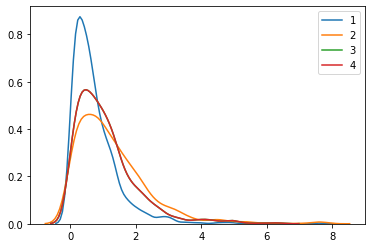

In [38]:
sns.distplot(np.abs(user_rating_list-real_rating), hist=False, kde=True, rug=False, bins=100, label='1')
sns.distplot(np.abs(user_rating_sub_list-real_rating), hist=False, kde=True, rug=False, bins=100, label='2')
sns.distplot(np.abs(user_rating_c_list-real_rating), hist=False, kde=True, rug=False, bins=100, label='3')
sns.distplot(np.abs(user_rating_c_sub_list-real_rating), hist=False, kde=True, rug=False, bins=100, label='4')

In [39]:
print('1 loss: %f'%np.mean(np.abs(user_rating_list-real_rating)))
print('2 loss: %f'%np.mean(np.abs(user_rating_sub_list-real_rating)))
print('3 loss: %f'%np.mean(np.abs(user_rating_c_list-real_rating)))
print('4 loss: %f'%np.mean(np.abs(user_rating_c_sub_list-real_rating)))

1 loss: 0.742275
2 loss: 1.274049
3 loss: 1.083875
4 loss: 1.083875
